# GeekBrains Credit Default Classification Course Project 2020-09-17

## Установка библиотек (если отсутствуют)

In [1]:
# %conda install --file requirements.txt

In [ ]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

# Подключение библиотек и скриптов

In [2]:
import datetime
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import sklearn
import xgboost as xgb
# 1. Разделение датасета и поиск гиперпараметров
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
# 2. Трансформация данных
from sklearn.preprocessing import StandardScaler
# 3. Модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# 4. Метрики качества
from sklearn.metrics import (classification_report, accuracy_score,
                             precision_score, f1_score,
                             confusion_matrix, plot_confusion_matrix,
                             auc, roc_auc_score, roc_curve, plot_roc_curve,
                             precision_recall_curve, plot_precision_recall_curve)

%matplotlib inline

In [3]:
import warnings
#warnings.filterwarnings('ignore')

**Скрипт для уменьшения занимаемой памяти DataFrame**

In [4]:
def reduce_mem_usage(df, *, verbose=False):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        From Kaggle Notebook:
        https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    """
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        mem_decrease_percent = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        print(f"Decreased by {mem_decrease_percent:.1f}%")
    
    return df

**Скрипт визуализации диаграммы распределения вероятности**

In [5]:
def plot_dist_with_stats(series: pd.Series, *, var_name: str='Variable', bins: int=30, log=False):
    plt.figure(figsize=(12, 6))
    
    distplot = sns.distplot(series, bins=bins, fit=norm,
                            hist_kws={'ec': 'white', 'log': log}, 
                            fit_kws={'label': 'Normal Distribution'})
    
    # Plotting the 3 averages
    tallest_bin_height = max([b.get_height() for b in distplot.patches])
    y = [0, tallest_bin_height]
    # Mean
    plt.plot([series.mean()] * len(y), y, color='green', linestyle='dashed', label='mean')
    # Median
    plt.plot([series.median()] * len(y), y, color='blue', linestyle='dashed', label='median')
    # Mode (adjusted)
    var_bin_count = len(series) // 100
    var_bin_range = (series.max() - series.min()) / var_bin_count
    var_bins = series // var_bin_range * var_bin_range
    adjusted_mode = var_bins.mode()[0]
    plt.plot([adjusted_mode] * len(y), y, color='red', linestyle='dashed', label='adjusted mode')

    plt.legend(loc='upper right')
    plt.title(f"Distribution of {var_name}")
    
    plt.show()

**Скрипт визуализации частоты значений переменной**

In [6]:
def plot_bar_frequency(series: pd.Series, *, show_labels=False, log=False):
    freq = series.value_counts()
    
    fig, ax = plt.subplots()
    ax.bar(freq.index, freq, log=log)
    
    ax.set_title(f"{'Log ' if log else ''}{series.name}")
    ax.set_ylabel('Frequency')
    
    if show_labels:
        for i, patch in enumerate(ax.patches):
            width = patch.get_x() + patch.get_width() / 2
            height = patch.get_height() + 5
            ax.annotate(freq[i],
                        (width, height),
                        ha='center',
                        va='bottom')
        
    return ax

**Скрипт для логирования каждой тренировки, оценки и кросс-валидации модели**

In [7]:
def log_model_results(model:sklearn.base.BaseEstimator,
                      accuracy:np.float64 = None,
                      f1_score:np.float64 = None,
                      cv_score:np.float64 = None,
                      comment:str = None,
                      train_log_path:str = "./training_log.csv",
                      *args, **kwargs) -> None:
    """ Function for logging trained model results on Credit Default dataset.
    Arguments:
        model - a Scikit-learn model that was trained,
        f1_score - F1 score calculated for the model on the training part of the train dataset,
        cv_score - cross-validation F1 score calculated for the model on the full train dataset,
        comment - a comment message for this model training,
        train_log_path - filepath for the training log of the models
    
    Returns:
        None
    """
    
    model_name = type(model).__name__
    model_params = repr(model.get_params())
    curr_datetime = datetime.datetime.now()
    date = curr_datetime.date()
    # Microseconds are not needed
    time = curr_datetime.time().replace(microsecond=0)
    
    log_string = f"{date};{time};{model_name};{accuracy if accuracy else ''};" + \
                 f"{f1_score if f1_score else ''};{cv_score if cv_score else ''};{model_params};" + \
                 f"{comment if comment else ''}\n"
    
    # Setup the log file if it's not created or is blank
    if not os.path.isfile(train_log_path):
        with open(train_log_path, 'w', encoding='utf-8'):
            pass
    if os.stat(train_log_path).st_size == 0:
        with open(train_log_path, 'w', encoding='utf-8') as file:
            file.write(f"date;time;model_type;accuracy;f1;cv_f1;hypers;comment\n")
    
    with open(train_log_path, 'a', encoding='utf-8') as file:
        file.write(log_string)
        print(log_string)

**Скрипт визуализации предсказаний модели**

In [8]:
def eval_predictions(train_true: pd.Series, train_pred: pd.Series, test_true: pd.Series, test_pred: pd.Series) -> None:
    
    """ THIS IS A TEMPLATE FOR REGRESSORS NOW"""
    
#     """ Evaluate model predictions with MSE, RMSE and R2 score.
#         Function from the GeekBrains tutorial notebook.
#     """
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
#     ax = ax.flatten()
    
#     print(f"Train R2:\t{round(r2(train_true, train_pred), 3)}", 
#           f"Train RMSE:\t{round(np.sqrt(mse(train_true, train_pred)), 3)}", 
#           f"Train MSE:\t{round(mse(train_true, train_pred), 3)}", 
#           sep='\n')
#     print()
#     print(f"Test R2:\t{round(r2(test_true, test_pred), 3)}", 
#           f"Test RMSE:\t{round(np.sqrt(mse(test_true, test_pred)), 3)}", 
#           f"Test MSE:\t{round(mse(test_true, test_pred), 3)}", 
#           sep='\n')
    
#     min_coord = min(train_true.min(), train_pred.min(), test_true.min(), test_pred.min())
#     max_coord = max(train_true.max(), train_pred.max(), test_true.max(), test_pred.max())
    
#     sns.scatterplot(x=train_pred, y=train_true, ax=ax[0])
#     ax[0].plot([min_coord, max_coord], [min_coord, max_coord], linestyle='--', color='black')
#     ax[0].set_title("Train dataset Prediction")
#     ax[0].set_xlabel("Predicted")
#     ax[0].set_ylabel("True")
    
#     sns.scatterplot(x=test_pred, y=test_true, ax=ax[1])
#     ax[1].plot([min_coord, max_coord], [min_coord, max_coord], linestyle='--', color='black')
#     ax[1].set_title("Test dataset Prediction")
#     ax[1].set_xlabel("Predicted")
#     ax[1].set_ylabel("True")
    
#     plt.show()

**Пути к файлам**

In [9]:
TRAIN_FILEPATH = './data/train.csv'
PREPARED_TRAIN_FILEPATH = './data/prepared_train.csv'
TEST_FILEPATH = './data/test.csv'
SCALER_FILEPATH = './scaler.pkl'
MODEL_FILEPATH = './model.pkl'
LOGFILE_FILEPATH = './training_log.csv'

# Загрузка данных в DataFrame

**Описание задачи**

Цель - предсказать, сможет ли человек выполнить свои кредитные обязательства.\
Тренировка модели классификации будет проходить на датасете course_project_train.csv с имеющимися целевыми значениями.\
Модель будет предсказывать результаты для датасета course_project_test.csv.

Эта цель может быть полезна для:
* банков и кредитных организаций, выдающих кредиты.

**Описание датасета**

В датасете описаны люди, взявшие кредиты, с различной информацией об их финансовом состоянии (признаки) и целевой переменной - факт невыполнения обязательств по кредиту Credit Default.\
Датасет является табличными, структурированными данными.

Признаки датасета:
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [10]:
train_df = pd.read_csv(TRAIN_FILEPATH, sep=',')
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [11]:
test_df = pd.read_csv(TEST_FILEPATH, sep=',')
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


Количество наблюдений в датасете.

In [12]:
print(f"Train samples: {train_df.shape[0]}")
print(f"Test samples: {test_df.shape[0]}")

Train samples: 7500
Test samples: 2500


Количество признаков в датасете (вместе с целевой переменной Price).

In [13]:
train_df.shape[1]

17

Проверяем, что в train и test одинаковое количество признаков.

In [14]:
train_df.shape[1] - 1 == test_df.shape[1]

True

**Уменьшаем занимаемую память DataFrame**

In [15]:
train_df = reduce_mem_usage(train_df, verbose=True)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


**Типы данных переменных**

In [16]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

# 1. EDA и Preprocessing

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## 1.1. Анализ таргета Credit Default

In [17]:
target = 'Credit Default'

In [18]:
train_df[target].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Классы несбалансированны.

## 1.2. Анализ признаков датасета

### 1.2.1. Количественные признаки

In [19]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130934,18.317467,9.451538e+05,0.170000,34.692600,0.117152,11873178.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688807,0.347192,31926124.0,3.178714e+05,11926.764648,1604.451416,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.000000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


Замеченные выбросы:
* Annual Income - max 10 000 000 выглядит многовато, но возможно в пределах нормы.
* Maximum Open Credit - max 1 304 000 000 значительно больше, все остальные статистики. Похоже, что лишние 3 нуля.\
* Current Loan Amount - max 100 000 000 также значительно больше остальных статистик. Лишние 2 нуля?\
* Credit Score - max 7510. Больше 1000 кредитный рейтинг не бывает. Этот выброс также тянет за собой медиану и стандартное отклонение.

### Annual Income

In [20]:
train_df['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

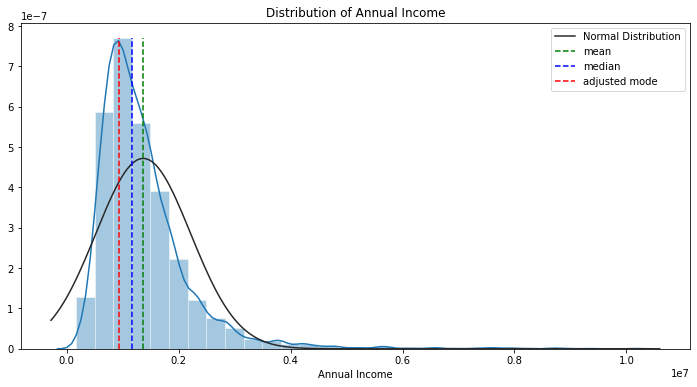

In [21]:
plot_dist_with_stats(train_df['Annual Income'], var_name='Annual Income')

In [22]:
train_df.loc[train_df['Annual Income'] > 4 * 10**6, 'Annual Income'].count()

91

Всего 91 (1.21%) значения больше 4 000 000.

Посмотрим на распределение без сильных выбросов (< 4 000 000).

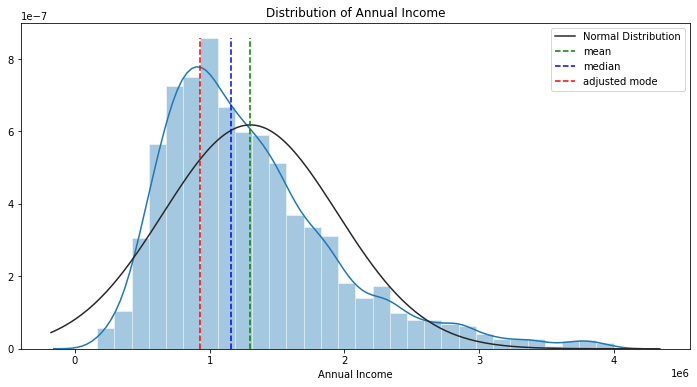

In [23]:
plot_dist_with_stats(train_df.loc[train_df['Annual Income'] < 4 * 10**6, 'Annual Income'], var_name='Annual Income')

### Tax Liens

In [24]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

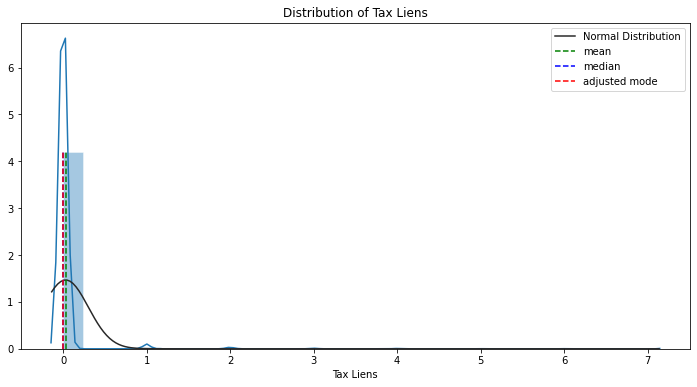

In [25]:
plot_dist_with_stats(train_df['Tax Liens'], var_name='Tax Liens')

### Number of Open Accounts

In [26]:
train_df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

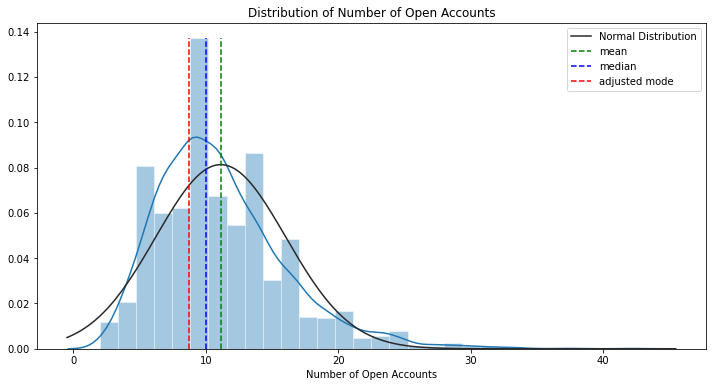

In [27]:
plot_dist_with_stats(train_df['Number of Open Accounts'], var_name='Number of Open Accounts')

### Years of Credit History

In [28]:
train_df['Years of Credit History'].value_counts()

15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
40.099998      1
39.500000      1
50.900002      1
44.299999      1
38.500000      1
Name: Years of Credit History, Length: 408, dtype: int64

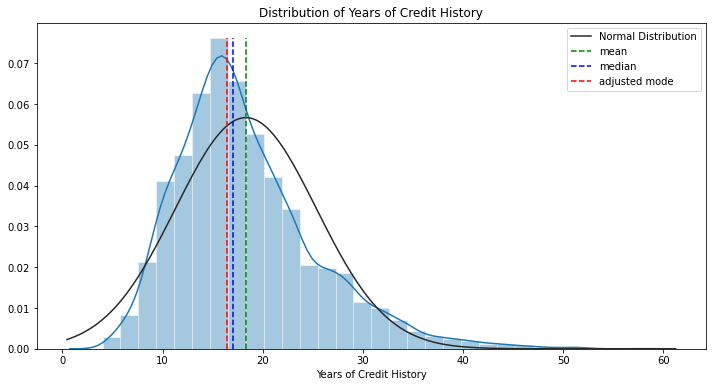

In [29]:
plot_dist_with_stats(train_df['Years of Credit History'], var_name='Years of Credit History')

### Maximum Open Credit

In [30]:
train_df['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

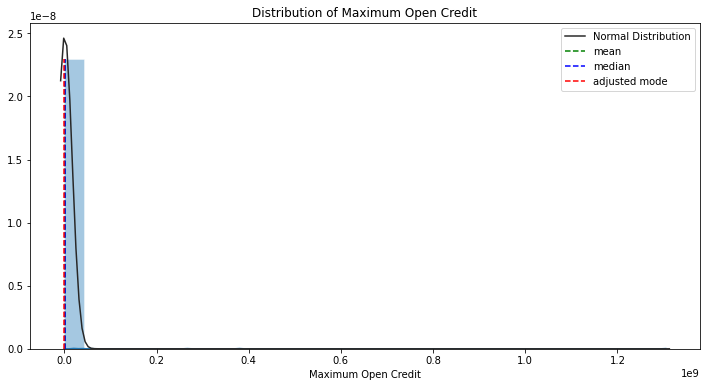

In [31]:
plot_dist_with_stats(train_df['Maximum Open Credit'], var_name='Maximum Open Credit')

In [32]:
train_df.loc[train_df['Maximum Open Credit'] > 4 * 10**6, 'Maximum Open Credit'].count()

64

Всего 64 (0.85%) значения больше 4 000 000.

Посмотрим на распределение без сильных выбросов (< 4 000 000).

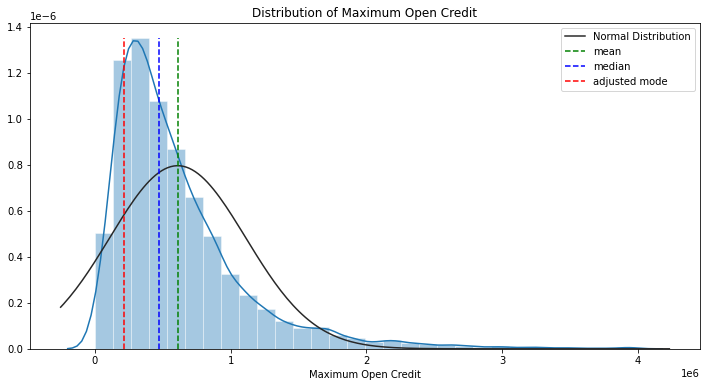

In [33]:
plot_dist_with_stats(train_df.loc[train_df['Maximum Open Credit'] < 4 * 10**6, 'Maximum Open Credit'], var_name='Maximum Open Credit')

### Number of Credit Problems

In [34]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

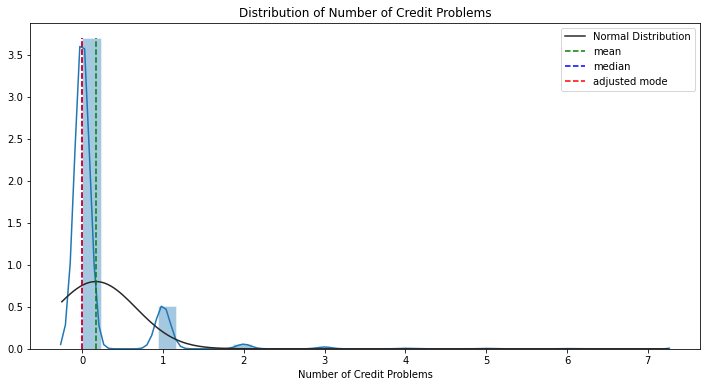

In [35]:
plot_dist_with_stats(train_df['Number of Credit Problems'], var_name='Number of Credit Problems')

### Months since last delinquent

In [36]:
train_df['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

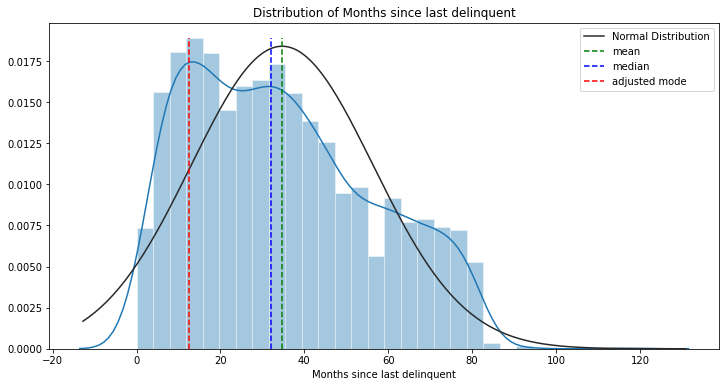

In [37]:
plot_dist_with_stats(train_df['Months since last delinquent'], var_name='Months since last delinquent')

### Bankruptcies

In [38]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

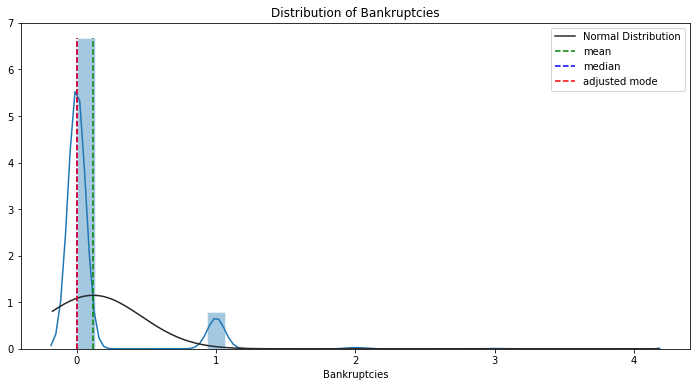

In [39]:
plot_dist_with_stats(train_df['Bankruptcies'], var_name='Bankruptcies')

### Current Loan Amount

In [40]:
train_df['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
270226.0         5
              ... 
490006.0         1
404756.0         1
194414.0         1
420376.0         1
33792.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

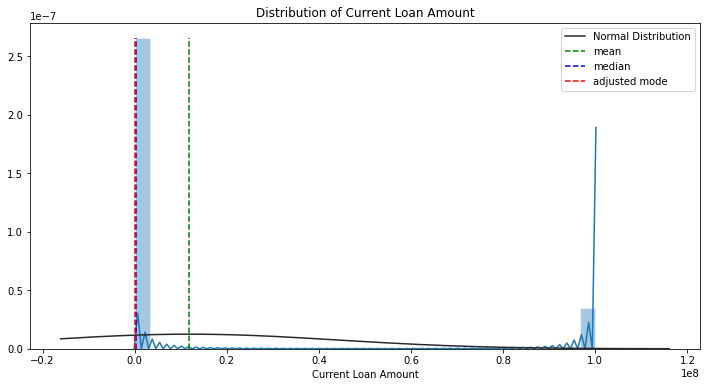

In [41]:
plot_dist_with_stats(train_df['Current Loan Amount'], var_name='Current Loan Amount')

In [42]:
train_df.loc[train_df['Current Loan Amount'] > 1 * 10**6, 'Current Loan Amount'].count()

870

870 (11.6%) значений больше 1 000 000.

Посмотрим на распределение без сильных выбросов (< 1 000 000).

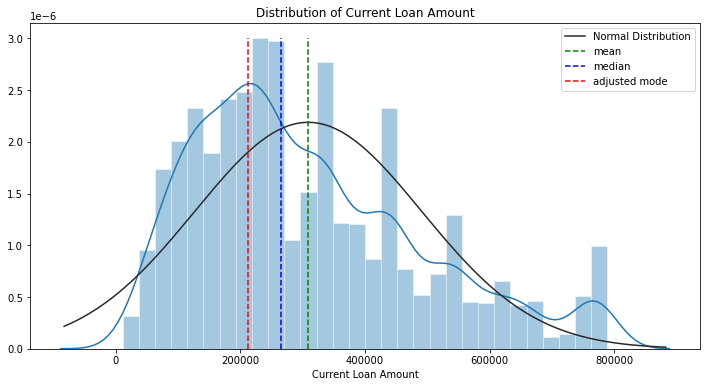

In [43]:
plot_dist_with_stats(train_df.loc[train_df['Current Loan Amount'] < 1 * 10**6, 'Current Loan Amount'], var_name='Current Loan Amount')

### Current Credit Balance

In [44]:
train_df['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

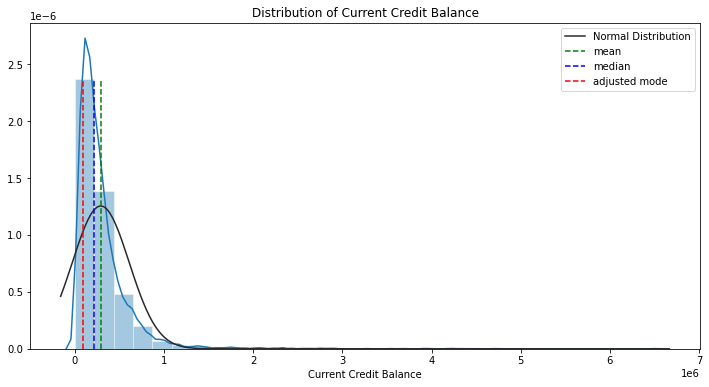

In [45]:
plot_dist_with_stats(train_df['Current Credit Balance'], var_name='Current Credit Balance')

In [46]:
train_df.loc[train_df['Current Credit Balance'] > 2 * 10**6, 'Current Credit Balance'].count()

41

41 (0.55%) значений больше 2 000 000.

Посмотрим на распределение без сильных выбросов (< 2 000 000).

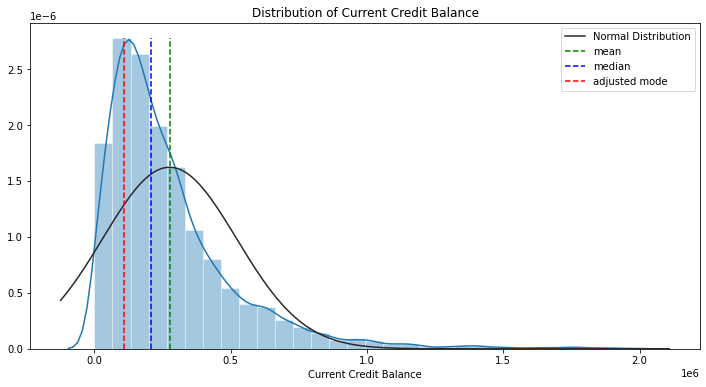

In [47]:
plot_dist_with_stats(train_df.loc[train_df['Current Credit Balance'] < 2 * 10**6, 'Current Credit Balance'], 
                     var_name='Current Credit Balance')

### Monthly Debt

In [48]:
train_df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

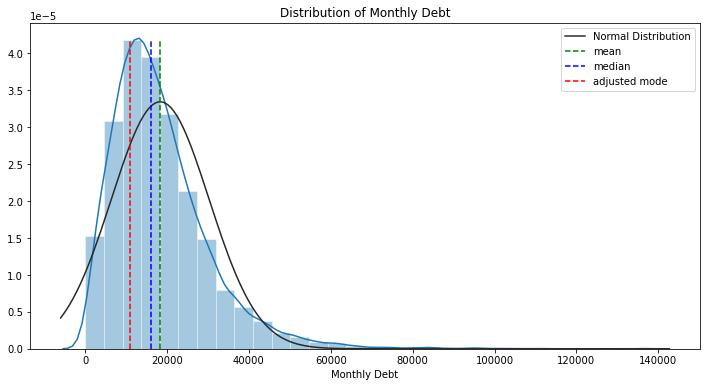

In [49]:
plot_dist_with_stats(train_df['Monthly Debt'], var_name='Monthly Debt')

### Credit Score

In [50]:
train_df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

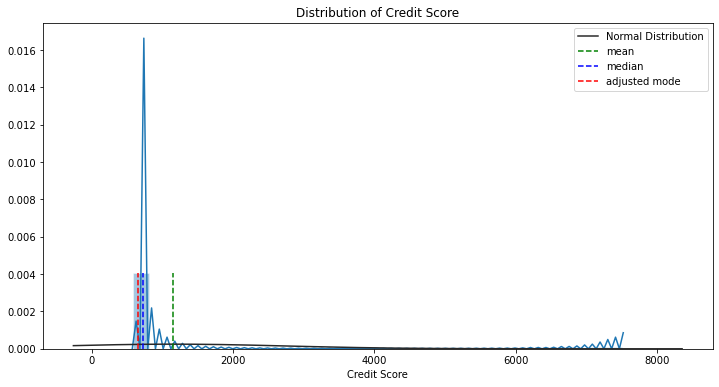

In [51]:
plot_dist_with_stats(train_df['Credit Score'], var_name='Credit Score')

In [52]:
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'].count()

400

400 (5.33%) значений больше 1000.

Посмотрим на распределение без сильных выбросов (< 1000).

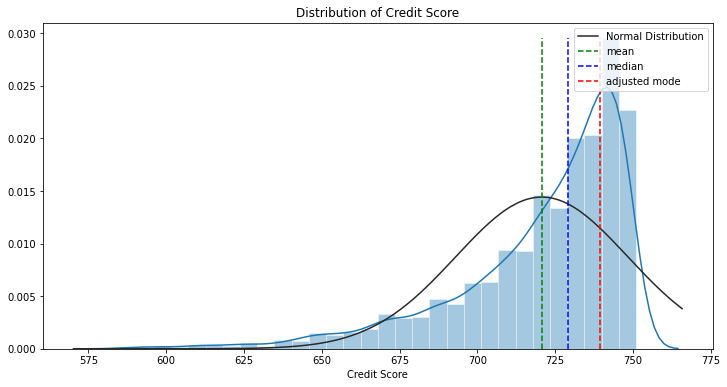

In [53]:
plot_dist_with_stats(train_df.loc[train_df['Credit Score'] < 1000, 'Credit Score'], var_name='Credit Score')

Распределение похоже на экспоненциальное.

### 1.2.2. Категориальные признаки

In [54]:
for feature in train_df.select_dtypes(include='category').columns:
    print(f"{feature}\n\n{train_df[feature].value_counts()}")
    print('-' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
----------------------------------------------------------------------------------------------------

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
----------------------------------------------------------------------------------------------------

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

## 1.3. Обработка выбросов

### Annual Income

In [55]:
ann_inc_median = train_df['Annual Income'].median()

In [56]:
train_df.loc[train_df['Annual Income'] > 4 * 10**6, 'Annual Income'] = ann_inc_median

### Tax Liens

### Number of Open Accounts

### Years of Credit History

### Maximum Open Credit

In [57]:
max_open_cred_median = train_df['Maximum Open Credit'].median()

In [58]:
train_df.loc[train_df['Maximum Open Credit'] > 4 * 10**6, 'Maximum Open Credit'] = max_open_cred_median

### Number of Credit Problems

### Months since last delinquent

### Bankruptcies

### Current Loan Amount

In [59]:
curr_loan_median = train_df['Current Loan Amount'].median()

In [60]:
train_df.loc[train_df['Current Loan Amount'] > 1 * 10**6, 'Current Loan Amount'] = curr_loan_median

### Current Credit Balance

In [61]:
curr_cred_bal_median = train_df['Current Credit Balance'].median()

In [62]:
train_df.loc[train_df['Current Credit Balance'] > 2 * 10**6, 'Current Credit Balance'] = curr_cred_bal_median

### Monthly Debt

### Credit Score

In [63]:
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'].describe()

count     400.000000
mean     7115.100098
std       306.745361
min      6060.000000
25%      6987.500000
50%      7190.000000
75%      7340.000000
max      7510.000000
Name: Credit Score, dtype: float64

400 выбросов со значениями в диапазоне [6060.0; 7510.0].\
Все похожи на то, что имеют лишний 0 на конце.\
Поделим все выбросы >= 3000 на 10 (начало кредитного рейтинга - 300 очков).

In [64]:
train_df.loc[train_df['Credit Score'] >= 3000, 'Credit Score'] //= 10

In [65]:
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score']

Series([], Name: Credit Score, dtype: float32)

Выбросов более 1000, но менее 3000 нет, но при их наличии в тестовом датасете стоит заменить их на медиану.

In [66]:
cred_score_median = train_df['Credit Score'].median()

In [67]:
train_df.loc[(train_df['Credit Score'] > 1000) & (train_df['Credit Score'] < 3000), 'Credit Score'] = cred_score_median

## 1.4. Обработка пропущенных значений

In [68]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Annual Income

In [69]:
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = ann_inc_median

### Years in current job

In [70]:
years_curr_job_mode = train_df['Years in current job'].mode()[0]

In [71]:
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] = years_curr_job_mode

### Months since last delinquent

In [72]:
train_df = train_df.drop(columns=['Months since last delinquent'])

### Bankruptcies

In [73]:
bankruptcy_median = train_df['Bankruptcies'].median()

In [74]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = bankruptcy_median

### Credit Score

In [75]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = cred_score_median

## 1.5. Зависимости между признаками, таргетом

## 1.6. Трансформация переменных

### Term

In [76]:
train_df['Term'] = pd.Series(train_df['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)

## 1.7. Генерация новых признаков

## 1.8. Отбор признаков

In [77]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [78]:
# features = ['ft1', 'ft2', 'ft3', 'ft4']
features = train_df.columns.tolist()
features.remove(target)
features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [79]:
new_features = []

## 1.9. Стандартизация

In [80]:
features_to_standard = train_df[features].select_dtypes(include=
                                                        ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
                                                       ).columns.tolist()
features_to_standard

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [81]:
scaler = StandardScaler()
standard_features = scaler.fit_transform(train_df[features_to_standard])

In [82]:
train_df[features_to_standard] = pd.DataFrame(standard_features, columns=features_to_standard)
train_df[features_to_standard]

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-1.379180,-0.110953,-0.026674,1.133645,0.154786,1.664779,2.545732,-0.591517,0.002830,-0.929272,-0.872085,1.076232
1,-0.430770,-0.110953,0.788223,-0.428528,1.148037,-0.340979,-0.337099,1.690569,-0.257436,0.487480,0.004909,0.599014
2,-0.909120,-0.110953,-0.026674,2.369181,1.149447,-0.340979,-0.337099,-0.591517,0.002830,0.134570,-0.391034,0.797855
3,-0.815473,-0.110953,-0.637847,0.593985,-0.924192,1.664779,2.545732,-0.591517,-1.095166,-0.731713,-0.584980,-1.111016
4,-0.865746,-0.110953,0.380774,-0.669954,-0.446497,1.664779,-0.337099,-0.591517,-1.069235,-0.742091,-0.933631,-0.116812
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.518623,-0.110953,-1.656468,-1.394234,-1.003396,-0.340979,-0.337099,-0.591517,-1.048697,-0.822864,-1.376362,-0.991711
7496,0.456723,-0.110953,-0.230398,1.162048,0.155492,-0.340979,-0.337099,1.690569,0.787479,0.737855,-0.463816,0.758087
7497,1.058732,-0.110953,0.177050,1.957336,2.344477,-0.340979,-0.337099,-0.591517,0.002830,0.825134,-0.489306,1.036463
7498,-0.181365,-0.110953,2.010568,1.162048,1.066937,-0.340979,-0.337099,-0.591517,1.786567,0.818009,1.576689,0.280869


## 1.10. Dummy-переменные

In [83]:
train_df = pd.get_dummies(train_df, drop_first=True)

У признака Years in current job есть значение "< 1 year".\
Этот значение конвертируется в dummy-признак с таким именем.

Алгоритм XGBoost не поддерживает символы '[', ']', '<'. в именах признаках.\
Заменим все запрещенные символы в названиях столбцов на приемлемые.

In [84]:
problem_chars = '[]<'
replacement = {'[': '(',
               ']': ')',
               '<': 'less_than'}

In [85]:
for colname in train_df.columns:
    for char in problem_chars:
        if char in colname:
            train_df = train_df.rename(columns={colname: colname.replace(char, replacement[char])})

In [86]:
train_df.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_10+ years', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job_less_than 1 year',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Pur

## 1.11. Балансировка классов

## 1.12. Описание обработанных данных

In [87]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000
mean,4.450480e-09,-1.449585e-08,6.357829e-09,-8.138021e-09,6.103515e-09,-1.678467e-08,-7.629395e-09,3.026327e-08,-8.646647e-09,-1.017253e-09,...,0.054933,0.005333,0.009467,0.001467,0.088667,0.000267,0.003467,0.004933,0.001067,0.00200
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,...,0.227865,0.072840,0.096842,0.038272,0.284281,0.016329,0.058780,0.070069,0.032645,0.04468
min,-1.933304e+00,-1.109534e-01,-1.860192e+00,-2.033305e+00,-1.219500e+00,-3.409789e-01,-3.370990e-01,-5.915167e-01,-1.737904e+00,-1.122416e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-5.954486e-01,-1.109534e-01,-6.378469e-01,-6.841558e-01,-6.600778e-01,-3.409789e-01,-3.370990e-01,-5.915167e-01,-7.522306e-01,-6.567092e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,-1.813647e-01,-1.109534e-01,-2.303985e-01,-1.871009e-01,-2.615436e-01,-3.409789e-01,-3.370990e-01,-5.915167e-01,2.797669e-03,-2.692593e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,3.289696e-01,-1.109534e-01,5.844983e-01,4.945742e-01,3.454918e-01,-3.409789e-01,-3.370990e-01,1.690569e+00,5.125469e-01,3.234933e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,4.756073e+00,2.566362e+01,6.492500e+00,5.592937e+00,6.752641e+00,1.369933e+01,1.119423e+01,1.690569e+00,2.800417e+00,6.970276e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


# 2. Классы генерации признаков и предобработки данных

## 2.1. Класс генерации признаков

In [88]:
class FeatureGenerator:
    """Class for generating new features for the Credit Default dataset."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass

## 2.2. Класс предобработки данных

In [506]:
class DataPipeline:
    """Class for cleaning data, transforming data, generating new features in the Credit Default dataset."""
    scaler_filepath = './scaler.pkl'
    scaler_type = StandardScaler
    
    def __init__(self, scaler_path=SCALER_FILEPATH):
        """"""
        self.NUM_FEATURE_TYPES = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
        self.FEATURES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 
                         'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                         'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        self.NEW_FEATURES = []
        self.TARGET_VARIABLE = 'Credit Default'
        
        self.medians = None
        self.modes = None
        
        self.features_to_standard = None
        self.scaler_filepath = scaler_path
        self.scaler = self.scaler_type()
        
        self.feature_gen = None
    
    def fit(self, X, y=None):
        """Fit the pipeline to the dataset."""
        self.medians = X.median()
        self.modes = X.select_dtypes(include=['object']).mode()
        
        # Train scaler
        self.features_to_standard = X[self.FEATURES].select_dtypes(include=self.NUM_FEATURE_TYPES).columns.tolist()
        self.scaler.fit(X[self.features_to_standard])
        # Save the scaler
        with open(self.scaler_filepath, 'wb') as file:
            pickle.dump(scaler, file)
    
    def transform(self, X, dummies=True):
        """Transform the dataset in order to make a better ML model."""
        X = DataPipeline.reduce_mem_usage(X)
        
        X = self.clean_outliers(X)
        X = self.fix_nan(X)
        X = self.term_to_int(X)
        
        X = self.standardize_features(X)
        
        if dummies:
            X = pd.get_dummies(X, drop_first=True)
        
        X = self.replace_problem_colnames(X)
        
        return X
    
    @staticmethod
    def reduce_mem_usage(df):
        """ Iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
            From Kaggle Notebook:
            https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
        """
        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    # Breaks statistics because of the Pandas issue
                    # if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #     df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        return df
    
    def clean_outliers(self, X):
        """ """
#         # Annual Income
#         train_df.loc[train_df['Annual Income'] > 4 * 10**6, 'Annual Income'] = self.medians['Annual Income']
#         # Maximum Open Credit
#         train_df.loc[train_df['Maximum Open Credit'] > 4 * 10**6, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
#         # Current Loan Amount
#         train_df.loc[train_df['Current Loan Amount'] > 1 * 10**6, 'Current Loan Amount'] = self.medians['Current Loan Amount']
#         # Current Credit Balance
#         train_df.loc[train_df['Current Credit Balance'] > 2 * 10**6, 'Current Credit Balance'] = self.medians['Current Credit Balance']
#         # Credit Score
#         train_df.loc[train_df['Credit Score'] >= 3000, 'Credit Score'] //= 10
#         train_df.loc[(train_df['Credit Score'] > 1000) & (train_df['Credit Score'] < 3000), 'Credit Score'] = self.medians['Credit Score']
        
        return X
    
    def fix_nan(self, X):
        """ """
        # Numerical features
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        # Categorical features
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.modes['Years in current job']
        
        # Drop Months since last delinquent since it is missing > 50% of values
        X = X.drop(columns=['Months since last delinquent'])
        
        return X
    
    def term_to_int(self, X):
        """Convert categorical string values of feature Term to binary 0 and 1."""
        X['Term'] = pd.Series(X['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)
        
        return X
    
    def standardize_features(self, X):
        """Standardize numerical features of a dataset."""
        standard_features = self.scaler.transform(X[self.features_to_standard])
        X[self.features_to_standard] = pd.DataFrame(standard_features, columns=self.features_to_standard)
        
        return X
    
    def replace_problem_colnames(self, X):
        """Replace banned in XGBoost characters in column names."""
        problem_chars = '[]<'
        replacement = {'[': '(',
                       ']': ')',
                       '<': 'less_than'}
        
        for colname in X.columns:
            for char in problem_chars:
                if char in colname:
                    X = X.rename(columns={colname: colname.replace(char, replacement[char])})
        
        return X

**Обработка датасетов классом DataPipeline**

Загрузим изначальные датасеты train, test и обработаем их с помощью класса DataPipeline.

In [507]:
train_df = pd.read_csv(TRAIN_FILEPATH)
test_df = pd.read_csv(TEST_FILEPATH)
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [508]:
pipeline = DataPipeline()
pipeline.fit(train_df)

train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)
train_df.shape, test_df.shape

((7500, 40), (2500, 38))

In [509]:
trn = set(train_df.columns.tolist())
tst = set(test_df.columns.tolist())

trn.remove('Credit Default')
differs = trn.symmetric_difference(tst)
differs

{'Purpose_renewable energy'}

Есть признаки в dummy-переменных, которые есть не в обоих датасетах.\
Исправим это.

In [510]:
if differs:
    differs = tuple(differs)
    print("Train" if differs[0] in trn else "Test")

Train


Этот признак есть в train датасете, но не в test.\
Добавим его с нулевыми значениями, так как это dummy-переменная общего признака Purpose.

In [511]:
if differs:
    test_df[differs[0]] = 0

train_df.shape, test_df.shape

((7500, 40), (2500, 39))

Теперь все признаки в датасетах одинаковы.

In [512]:
train_df.columns, test_df.columns

(Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
        'Years of Credit History', 'Maximum Open Credit',
        'Number of Credit Problems', 'Bankruptcies', 'Term',
        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
        'Credit Score', 'Credit Default', 'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home', 'Home Ownership_Rent',
        'Years in current job_10+ years', 'Years in current job_2 years',
        'Years in current job_3 years', 'Years in current job_4 years',
        'Years in current job_5 years', 'Years in current job_6 years',
        'Years in current job_7 years', 'Years in current job_8 years',
        'Years in current job_9 years', 'Years in current job_less_than 1 year',
        'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
        'Purpose_educational expenses', 'Purpose_home improvements',
        'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
        'Purpo

# 3. Сохранение обработанного датасета

In [513]:
train_df.to_csv(PREPARED_TRAIN_FILEPATH, sep=',', index=False, encoding='utf-8')

# 4. Разбиение на train, test

In [514]:
X = train_df.drop(target, axis=1)
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)

# 5. Построение модели

### LogisticRegression

In [515]:
model_params = {'solver': 'liblinear'}

In [516]:
lr_model = LogisticRegression(**model_params)

lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [517]:
y_pred = lr_model.predict(X_train)

In [518]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.779

In [519]:
f1 = f1_score(y_train, y_pred)
f1

0.4080357142857143

In [520]:
cv_score = cross_val_score(lr_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.42010772, 0.36563071, 0.40350877, 0.38756856, 0.40989399])

In [521]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.39734195070588946

In [341]:
comment = "Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing."

In [340]:
log_model_results(lr_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:09:53;LogisticRegression;0.7283333333333334;0.19862340216322516;0.16469335678024916;{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False};Processed outliers - median imputation and //= 10 for Credit Score >= 3000. Improved missing values processing - medians/modes imputation, dropped Months since last delinquent.



### SupportVectorClassifier

In [522]:
model_params = {'kernel': 'sigmoid'}

In [523]:
svc_model = SVC(**model_params)

svc_model.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [524]:
y_pred = svc_model.predict(X_train)

In [525]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.7103333333333334

In [526]:
f1 = f1_score(y_train, y_pred)
f1

0.41911764705882354

In [527]:
cv_score = cross_val_score(svc_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.4276885 , 0.42424242, 0.43309002, 0.43333333, 0.41019417])

In [528]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.4257096921980536

In [349]:
# comment = "Replaced KFold to StratifiedKFold"

In [350]:
log_model_results(svc_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:11:47;SVC;0.635;0.30696202531645567;0.30660137200428184;{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### KNN

In [529]:
model_params = {'n_neighbors': 5}

In [530]:
knn_model = KNeighborsClassifier(**model_params)

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [531]:
y_pred = knn_model.predict(X_train)

In [532]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.8195

In [533]:
f1 = f1_score(y_train, y_pred)
f1

0.6057517291590827

In [534]:
cv_score = cross_val_score(knn_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.4408284 , 0.42962963, 0.44117647, 0.40366972, 0.42433234])

In [535]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.42792731431380415

In [358]:
# comment = "Replaced KFold to StratifiedKFold"

In [359]:
log_model_results(knn_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:11:56;KNeighborsClassifier;0.7768333333333334;0.48951582157834544;0.24605448136871302;{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### DecisionTree

In [536]:
model_params = {'max_depth': 5,
                'min_samples_leaf': 10,
                'random_state': 42}

In [537]:
tree_model = DecisionTreeClassifier(**model_params)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

In [538]:
y_pred = tree_model.predict(X_train)

In [539]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.7778333333333334

In [540]:
f1 = f1_score(y_train, y_pred)
f1

0.4410901467505241

In [541]:
cv_score = cross_val_score(tree_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.46496815, 0.41237113, 0.44333333, 0.48367953, 0.46587537])

In [542]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.4540455032725255

In [543]:
# comment = "Replaced KFold to StratifiedKFold"

In [368]:
log_model_results(tree_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:12:01;DecisionTreeClassifier;0.7435;0.40418118466898956;0.2805289222702076;{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 42, 'splitter': 'best'};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### RandomForest

In [544]:
model_params = {'n_estimators': 100,
                'max_features': 20,
                'max_depth': 20,
                'min_samples_leaf': 3,
                'random_state': 42}

In [545]:
rf_model = RandomForestClassifier(**model_params)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=20, min_samples_leaf=3,
                       random_state=42)

In [546]:
y_pred = rf_model.predict(X_train)

In [547]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.9343333333333333

In [548]:
f1 = f1_score(y_train, y_pred)
f1

0.8683155080213903

In [549]:
cv_score = cross_val_score(rf_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.47947455, 0.43478261, 0.48154093, 0.45826514, 0.4502447 ])

In [550]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.46086158508732006

In [376]:
# comment = "Replaced KFold to StratifiedKFold"

In [377]:
log_model_results(rf_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:12:13;RandomForestClassifier;0.9556666666666667;0.9146889031430403;0.28953906664867;{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### GradientBoosting

In [551]:
model_params = {'criterion': 'mse',
                'n_estimators': 300,
                'max_depth': 5,
                'min_samples_leaf': 5,
                'random_state': 42}

In [552]:
gb_model = GradientBoostingClassifier(**model_params)

gb_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='mse', max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [553]:
y_pred = gb_model.predict(X_train)

In [554]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.9335

In [555]:
f1 = f1_score(y_train, y_pred)
f1

0.8680119086999669

In [556]:
cv_score = cross_val_score(rf_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.47947455, 0.43478261, 0.48154093, 0.45826514, 0.4502447 ])

In [557]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.46086158508732006

In [385]:
# comment = "Replaced KFold to StratifiedKFold"

In [386]:
log_model_results(gb_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:12:29;GradientBoostingClassifier;0.9373333333333334;0.876071193144364;0.28953906664867;{'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### XGBoost

In [558]:
model_params = {'objective': 'binary:logistic',
                'n_estimators': 10,
                'seed': 42,
                'max_depth': 6}

In [559]:
xgb_model = xgb.XGBClassifier(**model_params)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [560]:
y_pred = xgb_model.predict(X_train)

In [561]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.7925

In [562]:
f1 = f1_score(y_train, y_pred)
f1

0.45322793148880103

In [563]:
cv_score = cross_val_score(xgb_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.42179262, 0.38686131, 0.40484429, 0.39350181, 0.42248722])

In [564]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.40589745027560653

In [394]:
# comment = "Replaced KFold to StratifiedKFold"

In [395]:
log_model_results(xgb_model, accuracy, f1, mean_cv_score, comment)

2020-10-07;11:12:39;XGBClassifier;0.7918333333333333;0.48367093840429926;0.2710258202985269;{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 10, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'seed': 42};Processing outliers with median imputation makes the score much worse. Removing Annual Income outlier processing.



### catboost

In [ ]:
# ?

# 6. Настройка и валидация конечной модели

## 6.1. Оценка модели

## 6.2. Кросс-валидация

## 6.3. Логирование результатов валидации

In [78]:
# log_model_results(model, f1_score, mean_cv_score, comment=None)

# 7. Анализ прогнозов модели

## 7.1. Важность признаков

## 7.2. Топ-3 фичи

## 7.3. Худшие 3 фичи

# 8. Сохранение модели

**Создание файла requirements.txt для проекта**

In [565]:
%conda list -e > requirements.txt


Note: you may need to restart the kernel to use updated packages.


# 9. Прогнозирование на тестовом датасете

# 